In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from keras.layers import TFSMLayer
from PIL import Image 
import cv2

# 1. 모델 불러오기
model = keras.models.load_model('./MobileNetV2_binary.keras')

# 2. 테스트 이미지 파일 경로 설정
test_dir = './dataset/horse-or-human/test/'
  # 테스트 이미지가 있는 폴더 경로
image_size = (224, 224)  # 모델에 맞는 이미지 크기, 필요시 변경

In [9]:
# 3. 테스트 이미지 불러오기 및 전처리
def load_and_preprocess_image(img_path, target_size):
    try:
        # 이미지를 열고 강제로 RGB로 변환 (그레이스케일 이미지를 3차원으로 처리)
        img = Image.open(img_path).convert('RGB')
        
        # 이미지 크기 조정
        img = img.resize(target_size)
        
        # 이미지를 Numpy 배열로 변환 후 0-1 범위로 정규화
        img_array = np.array(img) / 255.0
        
        # 4차원 확장 (batch 차원 추가)
        img_array = np.expand_dims(img_array, axis=0)
        
        return img_array
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return None

# 4. 테스트 이미지와 레이블 불러오기
test_images = []
test_labels = []  # 실제 레이블 (0: horse, 1: human)
image_paths = [f for f in os.listdir(test_dir) if f.lower().endswith(('jpg', 'jpeg', 'png', 'webp'))]  # 이미지 파일만 선택
for img_path in image_paths:
    if 'horse' in img_path:  # 이미지 파일 이름에 'horse'이 포함된 경우
        test_labels.append(0)  # horse는 0
    elif 'human' in img_path:  # 이미지 파일 이름에 'human'이 포함된 경우
        test_labels.append(1)  # human은 1

    # 이미지 전처리
    img_array = load_and_preprocess_image(os.path.join(test_dir, img_path), image_size)
    if img_array is not None:
        test_images.append(img_array)

# Numpy 배열로 변환
if test_images:
    test_images = np.vstack(test_images)
    test_labels = np.array(test_labels)
else:
    print("No valid images were found.")

/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [10]:
# 이미지 전처리 및 누락된 이미지 확인
test_images = []
test_labels = []  # 실제 레이블 (0: horse, 1: human)

for img_path in image_paths:
    if 'horse' in img_path:
        test_labels.append(0)  # horse는 0
    elif 'human' in img_path:
        test_labels.append(1)  # human은 1

    img_array = load_and_preprocess_image(os.path.join(test_dir, img_path), image_size)
    
    if img_array is not None and img_array.shape == (1, image_size[0], image_size[1], 3):  # 4차원 배열 확인
        test_images.append(img_array)
    else:
        print(f"Skipping image due to processing error: {img_path}")

print(f"Processed images: {len(test_images)}, Processed labels: {len(test_labels)}")


Processed images: 235, Processed labels: 235


In [11]:
# 5. 예측 수행
# 먼저 test_images를 Numpy 배열로 변환
test_images = np.vstack(test_images)  # 여기가 중요! 배치로 묶어야 함

# 이제 모델에 올바르게 예측을 요청할 수 있음
predictions = model.predict(test_images)  # 배치 입력으로 예측 수행
predicted_labels = np.argmax(predictions, axis=1)  # 클래스별 확률에서 가장 높은 클래스 선택

# 예측된 레이블과 실제 레이블의 개수 확인
print(f"Number of test labels: {len(test_labels)}")
print(f"Number of predicted labels: {len(predicted_labels)}")

# 레이블 개수가 일치하지 않을 때 경고 메시지 출력
if len(test_labels) != len(predicted_labels):
    print("Mismatch in label counts!")
    print(f"Test labels: {len(test_labels)}, Predicted labels: {len(predicted_labels)}")
else:
    # 6. 성능 지표 계산 (개수가 일치할 때만 계산)
    accuracy = accuracy_score(test_labels, predicted_labels)
    precision = precision_score(test_labels, predicted_labels)
    recall = recall_score(test_labels, predicted_labels)
    f1 = f1_score(test_labels, predicted_labels)
    conf_matrix = confusion_matrix(test_labels, predicted_labels)

    # 성능 지표 출력
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print(f"Confusion Matrix:\n{conf_matrix}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 807ms/step
Number of test labels: 235
Number of predicted labels: 235
Accuracy: 0.5191489361702127
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
Confusion Matrix:
[[122   0]
 [113   0]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
# 8. 혼동 행렬 시각화 (Optional)
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Accuracy: 0.5191
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
ROC-AUC: 0.5000
Confusion Matrix:
[[122   0]
 [113   0]]


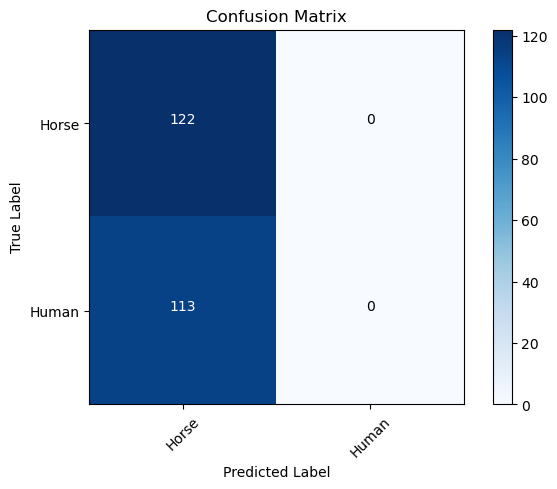

In [13]:
# ROC-AUC는 이진 레이블이 필요하므로 이를 위해 라벨을 변환
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
test_labels_binary = lb.fit_transform(test_labels)
predictions_binary = lb.transform(predicted_labels)
roc_auc = roc_auc_score(test_labels_binary, predictions_binary)

# 7. 결과 출력
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


class_names = ['Horse', 'Human']
plot_confusion_matrix(conf_matrix, class_names)
plt.show()

In [14]:
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow import keras

# 1. 모델 불러오기
model = keras.models.load_model('./MobileNetV2_binary_modify.keras')

# 테스트 이미지 경로
dlist = './dataset/horse-or-human/test/'
predict_list = [f for f in os.listdir(dlist) if f.lower().endswith(('jpg', 'jpeg', 'png', 'webp'))]  # 이미지 파일 목록
print(f"테스트 이미지 파일 목록: {predict_list}")

# 실제 레이블 설정 (파일 이름에 따라 설정)
true_labels = []
for file_name in predict_list:
    if "human" in file_name or "사람" in file_name:  # 사람을 나타내는 파일명에 따라 레이블 설정
        true_labels.append(1)  # 사람 -> 1
    elif "horse" in file_name or "말" in file_name:  # 말을 나타내는 파일명에 따라 레이블 설정
        true_labels.append(0)  # 말 -> 0

# 이미지 전처리 함수 정의
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is not None:
        resized_img = cv2.resize(image, (224, 224))  # MobileNetV2의 입력 크기
        return resized_img.astype('float32') / 255.0  # 정규화
    else:
        print(f"이미지 로드 실패: {image_path}")
        return None

# 이미지 전처리 및 예측 준비
img = []
for i in predict_list:
    img_path = os.path.join(dlist, i)
    processed_img = preprocess_image(img_path)
    
    if processed_img is not None:
        img.append(processed_img)

# 이미지가 정상적으로 로드되었는지 확인
if len(img) == 0:
    print("이미지를 불러오지 못했습니다. 경로를 확인하세요.")
else:
    img = np.array(img)  # 리스트를 numpy 배열로 변환

    # 분류 예측
    predictions = model.predict(img)  # 이미지에 대한 예측값
    predicted_labels = (predictions >= 0.5).astype(int).flatten()  # 임계값 설정 및 예측 결과 처리

    # 예측 결과 출력 및 정확도 계산
    correct_count = 0
    for idx, prediction in enumerate(predicted_labels):
        file_name = predict_list[idx]
        true_label = true_labels[idx]
        label_str = "사람" if prediction == 1 else "말"
        correct_count += 1 if prediction == true_label else 0  # 정답 카운트

        print(f"{file_name}: 예측 - {label_str}, 실제 - {'사람' if true_label == 1 else '말'}")

    # 전체 맞춘 비율 (정확도) 계산
    accuracy = correct_count / len(predicted_labels)
    print(f"\n전체 맞춘 비율(정확도): {accuracy * 100:.2f}%")


/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 322 variables whereas the saved optimizer has 326 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


테스트 이미지 파일 목록: ['human_081.jpeg', 'human_51.jpg', 'human_023.jpg', 'human_28.jpeg', 'horse_077.jpeg', 'horse_098.jpeg', 'horse_001.jpg', 'human_078.jpeg', 'human_097.jpeg', 'human_45.jpeg', 'horse_014.jpg', 'horse_26.jpeg', 'human_022.jpg', 'human_008.jpg', 'human_020.jpg', 'human_52.jpg', 'human_73.jpeg', 'horse_094.jpeg', 'horse_082.jpeg', 'horse_002.jpg', 'human_32.jpeg', 'horse_15.webp', 'human_49.jpeg', 'horse_003.jpg', 'horse_017.jpg', 'horse_016.jpeg', 'human_53.jpg', 'human_021.jpg', 'human_009.jpg', 'horse_057.jpeg', 'human_025.jpg', 'human_019.jpg', 'horse_013.jpg', 'horse_007.jpg', 'human_48.jpeg', 'human_33.jpeg', 'horse_083.jpeg', 'horse_006.jpg', 'horse_012.jpg', 'horse_095.jpeg', 'human_018.jpg', 'human_024.jpg', 'human_54.jpg', 'human_68.jpg', 'horse_004.jpg', 'horse_010.jpg', 'human_44.jpeg', 'human_079.jpeg', 'human_096.jpeg', 'horse_011.jpg', 'horse_005.jpg', 'horse_076.jpeg', 'horse_099.jpeg', 'human_29.jpeg', 'human_080.jpeg', 'human_75.jpeg', 'horse_41.jpeg', 'hor